## **Preprocessing**

In this section, we’ll transform our cleaned Apex Legends dataset into a ready‑to‑model format by:

- Loading the cleaned player retention dataset
- Auditing data and selecting features for modeling
- Handling missing values (if present)
- Encoding categorical variables (if any)
- Scaling features for model compatibility
- Addressing class imbalance using SMOTE
- Splitting data into training and testing sets
- Saving preprocessed data for downstream modeling


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [127]:
df = pd.read_csv('ApexPlayerRetention_final.csv', parse_dates=['date'])
print(f"Data shape: {df.shape}")
df.head()

Data shape: (499, 35)


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month
0,2022-11-03,1,broken moon,casual,846.0,S3,no,yes,5.0,1.0,...,0,1,0,0,1,1,0,0,Thursday,2022-11
1,2022-11-03,2,broken moon,casual,498.0,S3,no,yes,12.0,2.0,...,0,0,0,0,0,0,0,0,Thursday,2022-11
2,2022-11-03,3,broken moon,casual,498.0,S3,no,no,3.0,2.0,...,2,0,0,0,0,0,0,0,Thursday,2022-11
3,2022-11-03,4,broken moon,casual,498.0,S3,no,no,4.0,2.0,...,1,0,0,0,0,0,0,0,Thursday,2022-11
4,2022-11-03,5,broken moon,casual,498.0,S3,no,no,8.0,2.0,...,3,0,1,0,0,0,1,0,Thursday,2022-11


In [129]:
# Quality Check
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

# Statistics for numeric columns
print("\nSummary statistics:")
print(df.describe().T)

# Check class distribution for the target variable
print("\nRetention/Churn Distribution:")
print(df['retained'].value_counts())
print("\nProportion:")
print(df['retained'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                499 non-null    datetime64[ns]
 1   game                499 non-null    int64         
 2   map                 499 non-null    object        
 3   match_type          499 non-null    object        
 4   my_duration         499 non-null    float64       
 5   my_rank             499 non-null    object        
 6   premade_squad       499 non-null    object        
 7   voice_chat          499 non-null    object        
 8   squad_placed        499 non-null    float64       
 9   teamate_count       499 non-null    float64       
 10  teamate_quit_count  499 non-null    float64       
 11  my_legend           499 non-null    object        
 12  teamate_1_legend    499 non-null    object        
 13  teamate_2_legend    499 non-null    object        

In [131]:
# List columns with missing values
missing_cols = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_cols.tolist())

# Quick preview of missing data 
print("\nRows with missing values (preview):")
display(df[df.isnull().any(axis=1)].head())

assert df.isnull().sum().sum() == 0, "There are still missing values present!"

Columns with missing values: []

Rows with missing values (preview):


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month


Target variable unique values: [0 1]


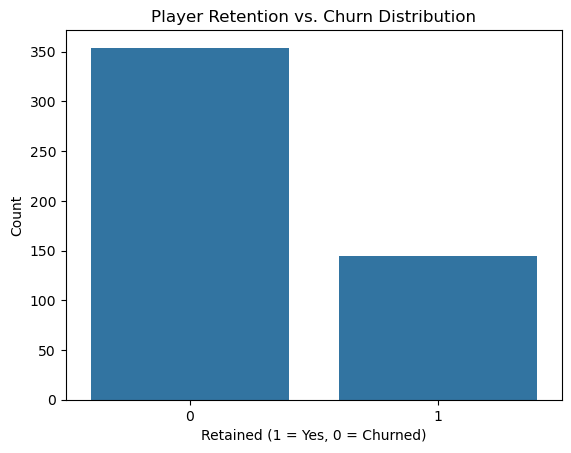

In [133]:
# Target variable values and unique classes
print("Target variable unique values:", df['retained'].unique())

# Visualize class distribution
sns.countplot(x='retained', data=df)
plt.title('Player Retention vs. Churn Distribution')
plt.xlabel('Retained (1 = Yes, 0 = Churned)')
plt.ylabel('Count')
plt.show()

# Split into features (X) and target (y)
X = df.drop(columns=['retained'])
y = df['retained']

In [134]:
# Ensure the split exists
if 'X_train' not in globals() or 'X_test' not in globals() or 'y_train' not in globals() or 'y_test' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

def _ensure_datetime(df, col='date'):
    if col in df.columns and not pd.api.types.is_datetime64_any_dtype(df[col]):
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def _roll_7d(g, legend_col, kills_col, dmg_col):
    # sort by time and use a datetime index for time-based windows
    g = g.sort_values('date').set_index('date', drop=False)

    # coerce numeric sources (avoids failures in rolling means)
    if kills_col:
        g[kills_col] = pd.to_numeric(g[kills_col], errors='coerce')
    if dmg_col:
        g[dmg_col] = pd.to_numeric(g[dmg_col], errors='coerce')

    # days_since_last_match
    if 'days_since_last_match' not in g.columns:
        g['days_since_last_match'] = g['date'].diff().dt.days.fillna(0)

    # session_frequency = matches in past 7 days
    if 'session_frequency' not in g.columns:
        g['_ones'] = 1
        g['session_frequency'] = g['_ones'].rolling('7D', min_periods=1).sum()
        g = g.drop(columns='_ones')

    # legend_diversity = unique legends in past 7 days
    if 'legend_diversity' not in g.columns:
        if legend_col and legend_col in g.columns:
            g['_legend_code'] = g[legend_col].astype('category').cat.codes.replace(-1, np.nan)
            g['legend_diversity'] = (
                g['_legend_code']
                .rolling('7D', min_periods=1)
                .apply(lambda x: pd.Series(x).dropna().nunique(), raw=False)
            )
            g = g.drop(columns='_legend_code')
        else:
            g['legend_diversity'] = 0.0

    # 4) 7-day rolling means for kills/damage
    if kills_col and 'avg_kills' not in g.columns:
        g['avg_kills'] = g[kills_col].rolling('7D', min_periods=1).mean()
    if dmg_col and 'avg_damage' not in g.columns:
        g['avg_damage'] = g[dmg_col].rolling('7D', min_periods=1).mean()

    return g.reset_index(drop=True)

def _make_cadence(df):
    df = df.copy()
    if 'date' not in df.columns:
        return df  
        
    _ensure_datetime(df, 'date')
    id_col = next((c for c in ['player_id','account_id','user_id','uid'] if c in df.columns), None)

    # Key columns
    kills_col = 'my_kills' if 'my_kills' in df.columns else None
    dmg_col = 'my_damage' if 'my_damage' in df.columns else None
    legend_col = 'my_legend' if 'my_legend' in df.columns else None
    dur_src_col = 'my_duration' if 'my_duration' in df.columns else ('duration' if 'duration' in df.columns else None)
    place_src = 'squad_placed' if 'squad_placed' in df.columns else None

    # apply per-player 
    if id_col:
        df = df.groupby(id_col, group_keys=False).apply(lambda g: _roll_7d(g, legend_col, kills_col, dmg_col))
    else:
        df = _roll_7d(df, legend_col, kills_col, dmg_col)

    # aliases (only if missing)
    if 'match_duration' not in df.columns and dur_src_col:
        df['match_duration'] = pd.to_numeric(df[dur_src_col], errors='coerce')
    if 'placement' not in df.columns and place_src:
        df['placement'] = pd.to_numeric(df[place_src], errors='coerce')

    # final numeric conversion + NA fill for the focus features
    for c in ['days_since_last_match','session_frequency','legend_diversity',
              'avg_kills','avg_damage','match_duration','placement']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    return df

# Apply to TRAIN and TEST independently
X_train = _make_cadence(X_train)
X_test  = _make_cadence(X_test)

_focus = ['days_since_last_match','session_frequency','legend_diversity', 'avg_kills','avg_damage','match_duration','placement']
created = [c for c in _focus if c in X_train.columns]
missing_after = [c for c in _focus if c not in X_train.columns]
print("Cadence features now in TRAIN:", created)
print("Still missing (if any):", "None" if not missing_after else missing_after)

Cadence features now in TRAIN: ['days_since_last_match', 'session_frequency', 'legend_diversity', 'avg_kills', 'avg_damage', 'match_duration', 'placement']
Still missing (if any): None


In [137]:
# Identify datetime and high-correlation leakage columns

# Ensure split exists
if 'X_train' not in globals() or 'y_train' not in globals() or 'X_test' not in globals() or 'y_test' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

# Key Features to protect
_protect = {
    'days_since_last_match',
    'session_frequency',
    'legend_diversity',
    'avg_kills',
    'avg_damage',
    'placement',
    'match_duration'
}

# Detect datetime columns
dt_cols = X_train.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns.tolist()
print("Detected datetime columns:", dt_cols if dt_cols else "None")

# Check that engineered time features exist
_required_time_feats = {'days_since_last_match', 'session_frequency', 'legend_diversity', 'avg_kills', 'avg_damage'}
_missing = sorted([c for c in _required_time_feats if c not in X_train.columns])

# Identify high-correlation numeric columns 
corrs = (X_train.assign(target=y_train.to_numpy()).corr(numeric_only=True)['target'].abs().sort_values(ascending=False))
leakage_cols = [c for c, v in corrs.items() if (v > 0.7 and c != 'target' and c not in _protect)]

# What I want to Drop
to_drop_now = leakage_cols.copy()
if dt_cols and not _missing:
    to_drop_now = sorted(set(to_drop_now + dt_cols))
elif dt_cols and _missing:
    print("Skipping drop of raw datetime columns until engineered features exist:", _missing)

# Apply drops 
if to_drop_now:
    print("Dropping leakage columns:", to_drop_now)
    X_train = X_train.drop(columns=to_drop_now, errors='ignore')
    X_test  = X_test.drop(columns=[c for c in to_drop_now if c in X_test.columns], errors='ignore')
else:
    print("No leakage columns dropped at this step.")

Detected datetime columns: None
No leakage columns dropped at this step.


In [139]:
# Identify categorical columns (object/category) and one-hot encode
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

# Encode TRAIN first and freeze the schema 
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
FEATURES = X_train.columns.tolist()

# Encode TEST and align to TRAIN schema
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
X_test = X_test.reindex(columns=FEATURES, fill_value=0)

print("Encoded features shape (train, test):", X_train.shape, X_test.shape)

Categorical columns: []
Encoded features shape (train, test): (399, 121) (100, 121)


In [141]:
# Re-align TEST to the frozen TRAIN schema (FEATURES) just in case
X_test = X_test.reindex(columns=FEATURES, fill_value=0)

# Hard assertions
assert list(X_train.columns) == FEATURES, "Train columns changed after locking schema."
assert list(X_test.columns)  == FEATURES, "Test columns do not match the train schema."

# NA check + shapes
print(f"Final train shape: {X_train.shape}")
print(f"Final test shape:  {X_test.shape}")
print("No missing values in train:", X_train.isnull().sum().sum() == 0)
print("No missing values in test:",  X_test.isnull().sum().sum() == 0)

Final train shape: (399, 121)
Final test shape:  (100, 121)
No missing values in train: True
No missing values in test: True


In [143]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [145]:
# SMOTE (Preview only) — keeps X_train / y_train unchanged
vc = y_train.value_counts()
k_neighbors = max(1, min(5, int(vc.min()) - 1))  # SMOTE needs k < minority count
print({"before_counts": vc.to_dict(), "k_neighbors": k_neighbors})

# Numeric working COPY for SMOTE (originals stay untouched)
X_train_preview = (X_train.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32))
y_train_preview = pd.Series(y_train).astype("int32")

# Preview resample for visualization
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_smote_preview, y_train_smote_preview = smote.fit_resample(X_train_preview, y_train_preview)

# Quick proportions
before_prop = y_train_preview.value_counts(normalize=True).round(3).to_dict()
after_prop  = pd.Series(y_train_smote_preview).value_counts(normalize=True).round(3).to_dict()
print("Proportions (before):", before_prop)
print("Proportions (after): ", after_prop)

# Back-compat aliases 
X_train_resampled, y_train_resampled = X_train, y_train

{'before_counts': {0: 283, 1: 116}, 'k_neighbors': 5}
Proportions (before): {0: 0.709, 1: 0.291}
Proportions (after):  {1: 0.5, 0: 0.5}


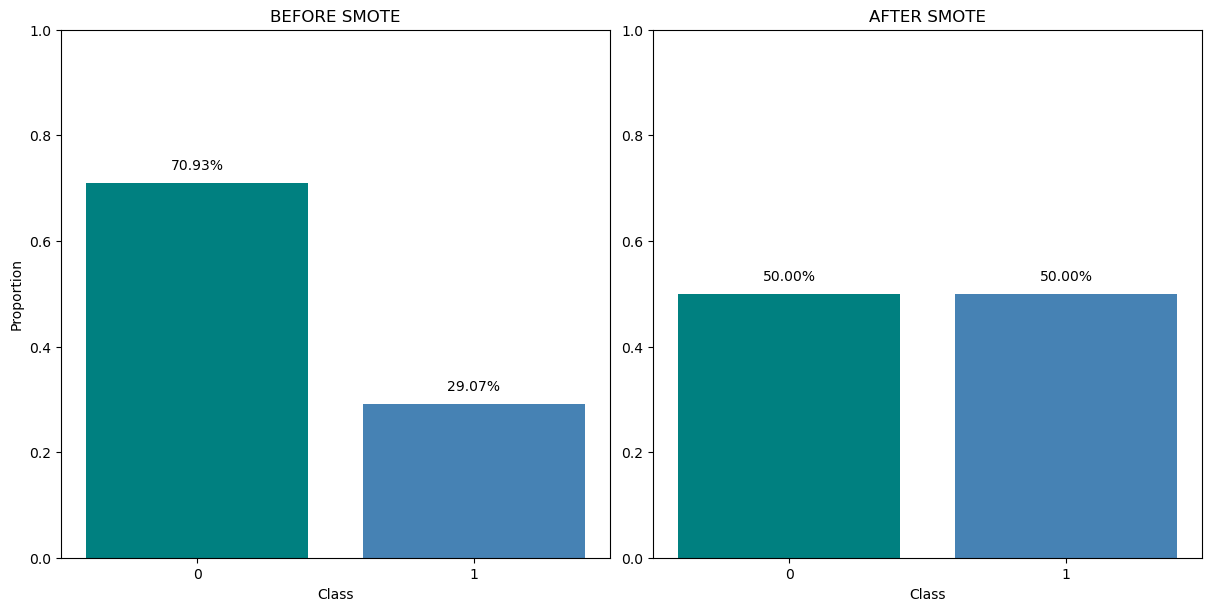

In [147]:
# Before and After SMOTE visual
from itertools import cycle 

# ensure preview variables exist
if 'y_train_preview' not in globals() or 'y_train_smote_preview' not in globals():
    raise NameError("Run the SMOTE preview cell first to define y_train_preview and y_train_smote_preview.")

before = pd.Series(y_train_preview).value_counts(normalize=True).sort_index()
after  = pd.Series(y_train_smote_preview).value_counts(normalize=True).sort_index()

# unify class order across both plots
classes = sorted(set(before.index).union(after.index))

color_list = ['teal', 'steelblue']
palette = {cls: col for cls, col in zip(classes, cycle(color_list))}

fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# BEFORE
vals_before = [before.get(c, 0.0) for c in classes]
bars = axs[0].bar(range(len(classes)), vals_before, color=[palette[c] for c in classes])
axs[0].set_xticks(range(len(classes)))
axs[0].set_xticklabels(classes)
axs[0].set_ylim(0, 1)
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Proportion")
axs[0].set_title("BEFORE SMOTE")
for i, b in enumerate(bars):
    axs[0].text(b.get_x() + b.get_width()/2, b.get_height() + 0.02,
                f"{vals_before[i]:.2%}", ha="center", va="bottom")

# AFTER
vals_after = [after.get(c, 0.0) for c in classes]
bars = axs[1].bar(range(len(classes)), vals_after, color=[palette[c] for c in classes])
axs[1].set_xticks(range(len(classes)))
axs[1].set_xticklabels(classes)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel("Class")
axs[1].set_title("AFTER SMOTE")
for i, b in enumerate(bars):
    axs[1].text(b.get_x() + b.get_width()/2, b.get_height() + 0.02,
                f"{vals_after[i]:.2%}", ha="center", va="bottom")

plt.show()

In [149]:
# Ensure columns match
assert list(X_train_resampled.columns) == FEATURES
assert list(X_test.columns) == FEATURES

print("Final train shape:", X_train_resampled.shape)
print("Final test shape:", X_test.shape)
print("No missing values in train:", X_train_resampled.isnull().sum().sum() == 0)
print("No missing values in test:", X_test.isnull().sum().sum() == 0)

Final train shape: (399, 121)
Final test shape: (100, 121)
No missing values in train: True
No missing values in test: True


In [151]:
# FINAL CHECK
import re

FOCUS = ["days_since_last_match", "session_frequency", "legend_diversity", "avg_kills", "avg_damage", "match_duration", "placement",]

# Focus features present and numeric
missing = [c for c in FOCUS if c not in X_train.columns]
non_numeric = [c for c in FOCUS if c in X_train.columns and not np.issubdtype(X_train[c].dtype, np.number)]

# Check one-hots exist
map_dummies = [c for c in X_train.columns if c.startswith("map_")]
legend_dummies = [c for c in X_train.columns if "legend_" in c]

# Schema lock + NA checks
if 'FEATURES' in globals():
    assert list(X_train.columns) == FEATURES, "Train columns changed after locking schema."
    assert list(X_test.columns)  == FEATURES, "Test columns do not match locked schema."
else:
    assert set(X_train.columns) == set(X_test.columns), "Train/test columns mismatch."

assert X_train.isnull().sum().sum() == 0, "NAs found in X_train."
assert X_test.isnull().sum().sum() == 0,  "NAs found in X_test."

print("Missing focus features:", missing if missing else "None")
print("Non-numeric focus features:", non_numeric if non_numeric else "None")
print("Map dummies found:", len(map_dummies))
print("Legend dummies found:", len(legend_dummies))
print(f"Shapes — train: {X_train.shape}, test: {X_test.shape}")
print("Preprocessing checks passed. Ready for modeling.")

Missing focus features: None
Non-numeric focus features: None
Map dummies found: 3
Legend dummies found: 68
Shapes — train: (399, 121), test: (100, 121)
Preprocessing checks passed. Ready for modeling.


In [153]:
# Sanity Check

FOCUS = ["days_since_last_match","session_frequency","legend_diversity", "avg_kills","avg_damage","match_duration","placement",]

present  = [c for c in FOCUS if c in X_train.columns]
missing  = [c for c in FOCUS if c not in X_train.columns]
dtypes   = X_train[ [c for c in FOCUS if c in X_train.columns] ].dtypes.astype(str).to_dict()

print("Present:", present)
print("Missing:", "None" if not missing else missing)
print("Dtypes:", dtypes)

Present: ['days_since_last_match', 'session_frequency', 'legend_diversity', 'avg_kills', 'avg_damage', 'match_duration', 'placement']
Missing: None
Dtypes: {'days_since_last_match': 'float64', 'session_frequency': 'float64', 'legend_diversity': 'float64', 'avg_kills': 'float64', 'avg_damage': 'float64', 'match_duration': 'float64', 'placement': 'float64'}


In [155]:
X_train_resampled.to_csv("X_train_resampled.csv", index=False)
y_train_resampled.to_csv("y_train_resampled.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

## **Modeling**

This section trains and evaluates multiple classification models including: `Logistic Regression`, `Random Forest`, and `XGBoost` to predict player retention in Apex Legends.  

Model performance will be assessed using metrics such as accuracy, ROC AUC, precision, recall, and F1 score, allowing for comparison across different algorithms.

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline

Best LR params: {'lr__C': 0.1, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best CV F1: 0.405
Logistic Regression (tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.13      0.22        71
           1       0.31      0.97      0.47        29

    accuracy                           0.37       100
   macro avg       0.61      0.55      0.35       100
weighted avg       0.73      0.37      0.29       100

Accuracy: 0.37
F1 Score: 0.47
Test ROC AUC: 0.516


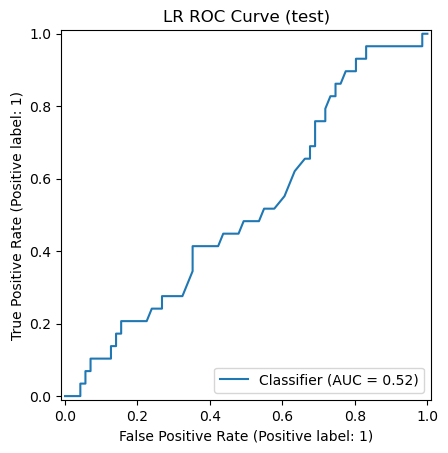

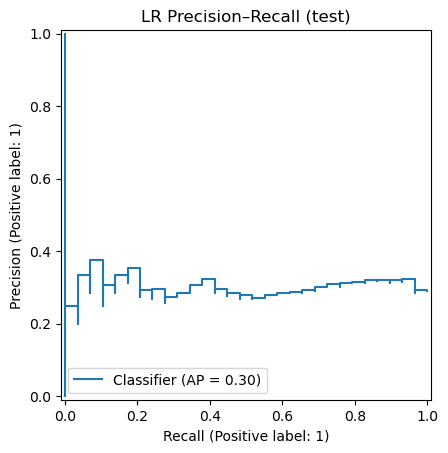

Top 10 by |coef|:


,feature,coef,abs_coef
0,my_assists,-0.132876,0.132876
1,day_of_week_Monday,0.127027,0.127027
2,teamate_1_knocks,-0.099290,0.099290
3,teamate_1_legend_Horizon,0.076393,0.076393
4,my_revives,0.069819,0.069819
5,voice_chat_yes,0.061878,0.061878
6,session_frequency,-0.055675,0.055675
7,teamate_2_assists,-0.026630,0.026630
8,teamate_count,-0.026541,0.026541
9,teamate_1_legend_Seer,0.000000,0.000000



Top 10 by permutation importance:


,feature,permutation_importance
0,teamate_1_knocks,0.022127
1,my_assists,0.013425
2,teamate_1_legend_Horizon,0.009256
3,session_frequency,0.003746
4,voice_chat_yes,0.002638
5,teamate_2_assists,0.002552
6,teamate_count,0.000627
7,teamate_1_legend_Seer,0.000000
8,teamate_1_legend_Rampart,0.000000
9,teamate_1_legend_Revenant,0.000000


,model,roc_auc,pr_auc,f1,precision,recall,accuracy
0,Logistic Regression — tuned,0.515784,0.304113,0.470588,0.311111,0.965517,0.37
1,Logistic Regression — baseline,0.397280,0.284760,0.314607,0.233333,0.482759,0.39


In [161]:
# Logistic Regression
def print_classification_results(y_true, y_pred, model_name="Model"):
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, digits=2))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")

# Hyperparameter tuning (SMOTE only inside CV) 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_base = LogisticRegression(max_iter=1000, random_state=42)
pipe = Pipeline(steps=[("smote", SMOTE(random_state=42)), ("lr", lr_base)])

param_grid = {
    "lr__penalty": ["l1", "l2"],
    "lr__C": [0.01, 0.1, 1.0, 10.0],
    "lr__solver": ["liblinear"],  
    "lr__class_weight": [None, "balanced"],   
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=0)

# Fit on training set
grid.fit(X_train, y_train)
print("Best LR params:", grid.best_params_)
print("Best CV F1:", f"{grid.best_score_:.3f}")

# Refit best model on full training set
logreg = grid.best_estimator_
logreg.fit(X_train, y_train)

# Test-set predictions/probabilities 
y_test_pred  = logreg.predict(X_test)
y_test_proba = logreg.predict_proba(X_test)[:, 1]

# Metrics & diagnostics
print_classification_results(y_test, y_test_pred, model_name="Logistic Regression (tuned)")
print("Test ROC AUC:", f"{roc_auc_score(y_test, y_test_proba):.3f}")

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("LR ROC Curve (test)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("LR Precision–Recall (test)")
plt.show()

# Feature importances (coefficients) 
lr_step = logreg.named_steps["lr"]
coef = lr_step.coef_.ravel()
fi_coef = (pd.DataFrame({"feature": X_train.columns, "coef": coef, "abs_coef": np.abs(coef)}) .sort_values("abs_coef", ascending=False).reset_index(drop=True))
print("Top 10 by |coef|:")
display(fi_coef.head(10))

# Permutation importance on TEST set
perm = permutation_importance(logreg, X_test, y_test, n_repeats=25, random_state=42, scoring="f1")
fi_perm = (pd.DataFrame({"feature": X_test.columns, "permutation_importance": perm.importances_mean}).sort_values("permutation_importance", ascending=False).reset_index(drop=True))
print("\nTop 10 by permutation importance:")
display(fi_perm.head(10))

# Results table: tuned vs baseline LR 
baseline_pipe = Pipeline(steps=[("smote", SMOTE(random_state=42)), ("lr", LogisticRegression(max_iter=1000, random_state=42, solver="liblinear"))])
baseline_pipe.fit(X_train, y_train)

y_pred_tuned,  y_proba_tuned  = y_test_pred, y_test_proba
y_pred_base   = baseline_pipe.predict(X_test)
y_proba_base  = baseline_pipe.predict_proba(X_test)[:, 1]

rows = []
for name, y_pred, y_proba in [
    ("Logistic Regression — tuned", y_pred_tuned, y_proba_tuned),
    ("Logistic Regression — baseline", y_pred_base,  y_proba_base),
]:
    rows.append({
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
    })

results_df = pd.DataFrame(rows)
display(results_df)

Best RF params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV F1: 0.182
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68        71
           1       0.23      0.24      0.24        29

    accuracy                           0.55       100
   macro avg       0.46      0.46      0.46       100
weighted avg       0.55      0.55      0.55       100

Accuracy: 0.55
F1 Score: 0.24
Test ROC AUC: 0.413


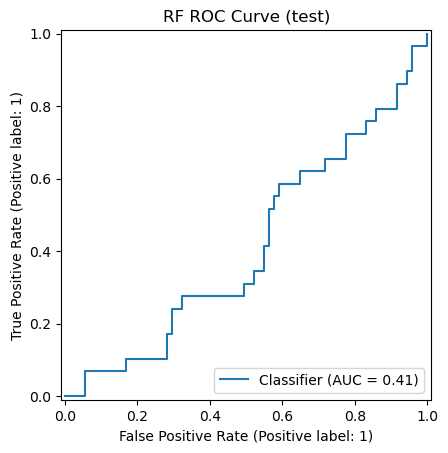

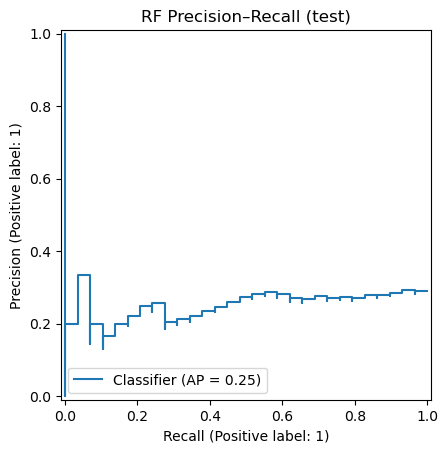

Top 15 RF features (native importance):


,feature,importance
0,session_frequency,0.078738
1,game,0.065729
2,avg_damage,0.051344
3,avg_kills,0.047793
4,placement,0.046601
5,squad_placed,0.046257
6,my_damage,0.045700
7,teamate_2_damage,0.042794
8,my_duration,0.042583
9,teamate_1_damage,0.040693



Top 10 by permutation importance (RF):


,feature,permutation_importance
0,my_duration,0.060361
1,days_since_last_match,0.060164
2,squad_placed,0.048969
3,placement,0.044834
4,teamate_2_damage,0.044732
5,day_of_week_Thursday,0.039084
6,teamate_1_knocks,0.035074
7,match_duration,0.034559
8,my_damage,0.030360
9,avg_kills,0.029931


,model,roc_auc,pr_auc,f1,precision,recall,accuracy
0,Random Forest (current),0.412822,0.254585,0.237288,0.233333,0.241379,0.55
1,Random Forest — simple baseline,0.465032,0.283170,0.000000,0.000000,0.000000,0.66


In [162]:
# Random Forest 

# Make sure X_* are DataFrames with feature names
if 'FEATURES' not in globals():
    if hasattr(X_train, "columns"):
        FEATURES = list(X_train.columns)
    else:
        raise NameError("FEATURES not found and X_train has no .columns; run encoding/schema-lock first.")

def _ensure_df(X, y_idx=None):
    if hasattr(X, "columns"):
        return X
    try:
        return pd.DataFrame(X, columns=FEATURES, index=y_idx)
    except Exception:
        return pd.DataFrame(X, columns=FEATURES)

X_train = _ensure_df(X_train, getattr(y_train, "index", None))
X_test  = _ensure_df(X_test,  getattr(y_test, "index", None))

# numeric & NA-safe
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0)

if 'print_classification_results' not in globals():
    def print_classification_results(y_true, y_pred, model_name="Model"):
        print(f"{model_name} Classification Report:")
        print(classification_report(y_true, y_pred, digits=2))
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")

# CV setup 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_base = RandomForestClassifier(random_state=42, n_estimators=300, n_jobs=-1)

# stable grid
param_grid = {
    "n_estimators": [300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1],
    "max_features": ["sqrt"],
    "class_weight": [None, "balanced"],
}

grid_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=0)

# Tune 
try:
    grid_rf.fit(X_train, y_train)
    rf = grid_rf.best_estimator_
    print("Best RF params:", grid_rf.best_params_)
    print("Best CV F1:", f"{grid_rf.best_score_:.3f}")
except Exception as e:
    print("GridSearch failed; using baseline RF. Reason:", type(e).__name__, str(e)[:200])
    rf = rf_base.fit(X_train, y_train)

# Fit best/baseline on full train
rf.fit(X_train, y_train)

# Test predictions/probas
y_test_pred_rf  = rf.predict(X_test)
y_test_proba_rf = rf.predict_proba(X_test)[:, 1]

# Metrics & diagnostics
print_classification_results(y_test, y_test_pred_rf, model_name="Random Forest")
print("Test ROC AUC:", f"{roc_auc_score(y_test, y_test_proba_rf):.3f}")

RocCurveDisplay.from_predictions(y_test, y_test_proba_rf)
plt.title("RF ROC Curve (test)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba_rf)
plt.title("RF Precision–Recall (test)")
plt.show()

# feature importances (Gini)
fi_rf = (pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_}).sort_values("importance", ascending=False).reset_index(drop=True))
print("Top 15 RF features (native importance):")
display(fi_rf.head(15))

# Permutation importance on TEST 
perm_rf = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring="f1")
fi_perm_rf = (pd.DataFrame({"feature": X_test.columns, "permutation_importance": perm_rf.importances_mean}).sort_values("permutation_importance", ascending=False).reset_index(drop=True))
print("\nTop 10 by permutation importance (RF):")
display(fi_perm_rf.head(10))

# Results 
baseline_rf = RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1).fit(X_train, y_train)
y_pred_base_rf  = baseline_rf.predict(X_test)
y_proba_base_rf = baseline_rf.predict_proba(X_test)[:, 1]

rf_results = pd.DataFrame([
    {
        "model": "Random Forest (current)",
        "roc_auc": roc_auc_score(y_test, y_test_proba_rf),
        "pr_auc":  average_precision_score(y_test, y_test_proba_rf),
        "f1":      f1_score(y_test, y_test_pred_rf),
        "precision": precision_score(y_test, y_test_pred_rf),
        "recall":    recall_score(y_test, y_test_pred_rf),
        "accuracy":  accuracy_score(y_test, y_test_pred_rf),
    },
    {
        "model": "Random Forest — simple baseline",
        "roc_auc": roc_auc_score(y_test, y_proba_base_rf),
        "pr_auc":  average_precision_score(y_test, y_proba_base_rf),
        "f1":      f1_score(y_test, y_pred_base_rf),
        "precision": precision_score(y_test, y_pred_base_rf),
        "recall":    recall_score(y_test, y_pred_base_rf),
        "accuracy":  accuracy_score(y_test, y_pred_base_rf),
    },
])
display(rf_results)

Best XGB params: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV F1: 0.192
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        71
           1       0.30      0.24      0.27        29

    accuracy                           0.62       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.60      0.62      0.61       100

Accuracy: 0.62
F1 Score: 0.27
Test ROC AUC: 0.492


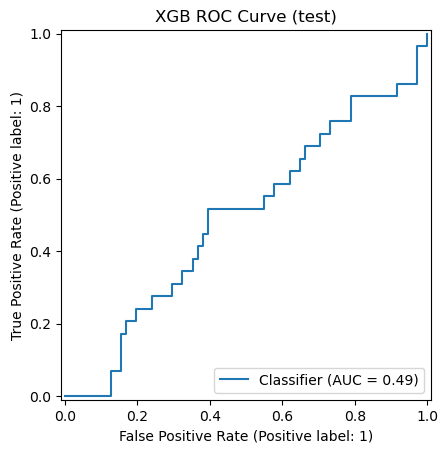

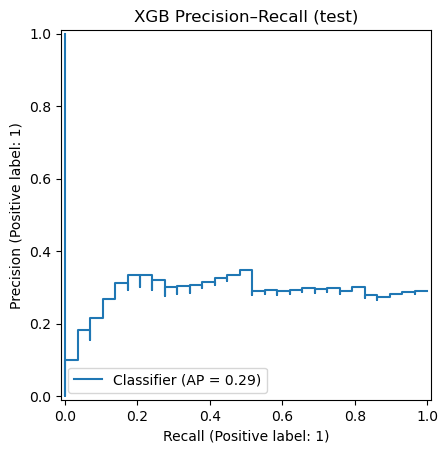

Top 15 XGB features (native importance):


,feature,importance
0,teamate_2_respawns,0.046876
1,my_legend_Crypto,0.041432
2,teamate_1_legend_Lifeline,0.039495
3,teamate_1_legend_Horizon,0.034527
4,teamate_1_knocks,0.033388
5,teamate_2_legend_Pathfinder,0.029404
6,teamate_2_legend_Valkyrie,0.028260
7,my_assists,0.026967
8,teamate_1_kills,0.025439
9,voice_chat_yes,0.025403



Top 10 by permutation importance (XGB):


,feature,permutation_importance
0,teamate_2_damage,0.078100
1,session_frequency,0.037330
2,day_of_week_Monday,0.022343
3,teamate_2_assists,0.019523
4,placement,0.016460
5,teamate_1_revives,0.014425
6,my_damage,0.012941
7,my_rank_P1,0.011118
8,my_legend_Catalyst,0.009760
9,premade_squad_yes,0.006894


,model,roc_auc,pr_auc,f1,precision,recall,accuracy
0,XGBoost (current),0.491986,0.288076,0.269231,0.304348,0.241379,0.62
1,XGBoost — simple baseline,0.440505,0.259862,0.156863,0.181818,0.137931,0.57


In [163]:
# XGBoost 

# Ensure DataFrames with feature names 
if 'FEATURES' not in globals():
    if hasattr(X_train, "columns"):
        FEATURES = list(X_train.columns)
    else:
        raise NameError("FEATURES not found; run the encoding/schema-lock cell first.")

def _ensure_df(X, y_idx=None):
    if hasattr(X, "columns"):
        return X
    try:
        return pd.DataFrame(X, columns=FEATURES, index=y_idx)
    except Exception:
        return pd.DataFrame(X, columns=FEATURES)

X_train = _ensure_df(X_train, getattr(y_train, "index", None))
X_test = _ensure_df(X_test,  getattr(y_test, "index", None))

# numeric & NA-safe
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0)

# helper (define if LR cell didn't)
if 'print_classification_results' not in globals():
    def print_classification_results(y_true, y_pred, model_name="Model"):
        print(f"{model_name} Classification Report:")
        print(classification_report(y_true, y_pred, digits=2))
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")

# Base model
xgb_base = XGBClassifier(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=5, subsample=1.0, colsample_bytree=1.0, min_child_weight=1, gamma=0, tree_method="hist", eval_metric="logloss", n_jobs=-1)

# 3-fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param_dist = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3],
    "gamma": [0, 1]
}

grid_xgb = RandomizedSearchCV(estimator=xgb_base, param_distributions=param_dist, n_iter=15, cv=cv, scoring="f1", n_jobs=-1, random_state=42, verbose=0)

# Tune 
try:
    grid_xgb.fit(X_train, y_train)
    xgb = grid_xgb.best_estimator_
    print("Best XGB params:", grid_xgb.best_params_)
    print("Best CV F1:", f"{grid_xgb.best_score_:.3f}")
except Exception as e:
    print("RandomizedSearch failed; using baseline XGB. Reason:", type(e).__name__, str(e)[:200])
    xgb = xgb_base.fit(X_train, y_train)

# Fit best/baseline on full train
xgb.fit(X_train, y_train)

# Test predictions/probas
y_test_pred_xgb  = xgb.predict(X_test)
y_test_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Metrics & diagnostics
print_classification_results(y_test, y_test_pred_xgb, model_name="XGBoost")
print("Test ROC AUC:", f"{roc_auc_score(y_test, y_test_proba_xgb):.3f}")

RocCurveDisplay.from_predictions(y_test, y_test_proba_xgb)
plt.title("XGB ROC Curve (test)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba_xgb)
plt.title("XGB Precision–Recall (test)")
plt.show()

# Native feature importances (gain)
fi_xgb = (pd.DataFrame({"feature": X_train.columns, "importance": xgb.feature_importances_}).sort_values("importance", ascending=False).reset_index(drop=True))
print("Top 15 XGB features (native importance):")
display(fi_xgb.head(15))

# Permutation importance on TEST 
perm_xgb = permutation_importance(
    xgb, X_test, y_test, n_repeats=10, random_state=42, scoring="f1")
fi_perm_xgb = (pd.DataFrame({"feature": X_test.columns, "permutation_importance": perm_xgb.importances_mean}).sort_values("permutation_importance", ascending=False).reset_index(drop=True))
print("\nTop 10 by permutation importance (XGB):")
display(fi_perm_xgb.head(10))

# Results 
xgb_baseline = XGBClassifier(random_state=42, n_estimators=300, max_depth=5, learning_rate=0.1,subsample=1.0, colsample_bytree=1.0, min_child_weight=1,gamma=0, tree_method="hist", eval_metric="logloss", n_jobs=-1).fit(X_train, y_train)

y_pred_base_xgb  = xgb_baseline.predict(X_test)
y_proba_base_xgb = xgb_baseline.predict_proba(X_test)[:, 1]

xgb_results = pd.DataFrame([
    {
        "model": "XGBoost (current)",
        "roc_auc": roc_auc_score(y_test, y_test_proba_xgb),
        "pr_auc":  average_precision_score(y_test, y_test_proba_xgb),
        "f1":      f1_score(y_test, y_test_pred_xgb),
        "precision": precision_score(y_test, y_test_pred_xgb),
        "recall":    recall_score(y_test, y_test_pred_xgb),
        "accuracy":  accuracy_score(y_test, y_test_pred_xgb),
    },
    {
        "model": "XGBoost — simple baseline",
        "roc_auc": roc_auc_score(y_test, y_proba_base_xgb),
        "pr_auc":  average_precision_score(y_test, y_proba_base_xgb),
        "f1":      f1_score(y_test, y_pred_base_xgb),
        "precision": precision_score(y_test, y_pred_base_xgb),
        "recall":    recall_score(y_test, y_pred_base_xgb),
        "accuracy":  accuracy_score(y_test, y_pred_base_xgb),
    },
])
display(xgb_results)

In [180]:
# ALL RESULTS

tables = []

# Collect per-model result tables
if 'results_df' in globals():   # from LR cell
    tables.append(results_df.copy())
if 'rf_results' in globals():   # from RF cell
    tables.append(rf_results.copy())
if 'xgb_results' in globals():  # from XGB cell
    tables.append(xgb_results.copy())

if tables:
    all_results = pd.concat(tables, ignore_index=True)

    # Ensure consistent column order 
    metric_order = ["model", "f1", "pr_auc", "roc_auc", "precision", "recall", "accuracy"]
    for col in metric_order:
        if col not in all_results.columns:
            all_results[col] = np.nan
    all_results = all_results[metric_order]

    # Round for readability and sort by your priority
    all_results_rounded = all_results.copy()
    for m in ["f1","pr_auc","roc_auc","precision","recall","accuracy"]:
        all_results_rounded[m] = all_results_rounded[m].astype(float).round(3)

    all_results_sorted = all_results_rounded.sort_values(["f1", "pr_auc", "roc_auc"], ascending=[False, False, False]).reset_index(drop=True)

    display(all_results_sorted)

    # Identify the current best model by priority
    best_model = all_results_sorted.iloc[0]["model"]
    print(f"Best model by F1 -> PR AUC -> ROC AUC: {best_model}")
else:
    print("No results tables found. Run the LR, RF, and/or XGB cells first.")

,model,f1,pr_auc,roc_auc,precision,recall,accuracy
0,Logistic Regression — tuned,0.471,0.304,0.516,0.311,0.966,0.37
1,Logistic Regression — baseline,0.315,0.285,0.397,0.233,0.483,0.39
2,XGBoost (current),0.269,0.288,0.492,0.304,0.241,0.62
3,Random Forest (current),0.237,0.255,0.413,0.233,0.241,0.55
4,XGBoost — simple baseline,0.157,0.260,0.441,0.182,0.138,0.57
5,Random Forest — simple baseline,0.000,0.283,0.465,0.000,0.000,0.66


Best model by F1 -> PR AUC -> ROC AUC: Logistic Regression — tuned


In [165]:
# Model comparison visual

CHURN_LABEL = 1  

def _first_existing(*names):
    for n in names:
        if n in globals():
            return globals()[n]
    return None

def _ensure_df(X, y_idx=None):
    if hasattr(X, "columns"):
        return X
    return pd.DataFrame(X, columns=FEATURES, index=y_idx)

# LR predictions
y_pred_lr = _first_existing("y_test_pred_lr", "y_test_pred", "y_test_pred_logreg")
if y_pred_lr is None:
    Xte_lr = _first_existing("X_test_std") or X_test  # LR often uses scaled features
    logreg_model = _first_existing("logreg", "logreg_tuned", "lr", "clf_lr")
    if logreg_model is None:
        raise NameError("Couldn't find LR predictions or model (expected y_test_pred or logreg).")
    y_pred_lr = logreg_model.predict(Xte_lr)

# RF predictions
y_pred_rf = _first_existing("y_test_pred_rf")
if y_pred_rf is None:
    rf_model = _first_existing("rf", "rf_best", "rf_model")
    if rf_model is None:
        raise NameError("Couldn't find RF predictions or model (expected y_test_pred_rf or rf).")
    Xte_rf = _ensure_df(X_test, getattr(y_test, "index", None))
    y_pred_rf = rf_model.predict(Xte_rf)

# XGB predictions
y_pred_xgb = _first_existing("y_test_pred_xgb")
if y_pred_xgb is None:
    xgb_model = _first_existing("xgb", "xgb_best", "xgb_model")
    if xgb_model is None:
        raise NameError("Couldn't find XGB predictions or model (expected y_test_pred_xgb or xgb).")
    Xte_xgb = _ensure_df(X_test, getattr(y_test, "index", None))
    y_pred_xgb = xgb_model.predict(Xte_xgb)

#compute metrics (overall + per-class) ---
labels = sorted(pd.Series(y_test).unique().tolist())
if CHURN_LABEL not in labels:
    CHURN_LABEL = max(labels)
RETAIN_LABEL = [l for l in labels if l != CHURN_LABEL][0]

def _row(model_name, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    p_churn = precision_score(y_test, y_pred, pos_label=CHURN_LABEL, zero_division=0)
    p_ret   = precision_score(y_test, y_pred, pos_label=RETAIN_LABEL, zero_division=0)
    r_churn = recall_score(y_test, y_pred, pos_label=CHURN_LABEL, zero_division=0)
    r_ret   = recall_score(y_test, y_pred, pos_label=RETAIN_LABEL, zero_division=0)
    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Precision (Churned/Retained)": f"{p_churn:.2f} / {p_ret:.2f}",
        "Recall (Churned/Retained)":    f"{r_churn:.2f} / {r_ret:.2f}",
    }

rows = [_row("Logistic Regression", y_pred_lr), _row("Random Forest", y_pred_rf), _row("XGBoost", y_pred_xgb),]

tbl = pd.DataFrame(rows)

# round numeric display cols
for c in ["Accuracy","F1 Score"]:
    tbl[c] = tbl[c].astype(float).round(2)

# highlight best F1 row 
best_idx = tbl["F1 Score"].astype(float).idxmax()

def _highlight_best(row):
    return ['background-color: lightblue' if row.name == best_idx else '' for _ in row]

styled_tbl = (tbl.style.apply(_highlight_best, axis=1).set_table_styles([{"selector":"th","props":[("text-align","left"),("font-weight","bold")]},{"selector":"td","props":[("text-align","center")]},]))

display(styled_tbl)

,Model,Accuracy,F1 Score,Precision (Churned/Retained),Recall (Churned/Retained)
0,Logistic Regression,0.370000,0.470000,0.31 / 0.90,0.97 / 0.13
1,Random Forest,0.550000,0.240000,0.23 / 0.69,0.24 / 0.68
2,XGBoost,0.620000,0.270000,0.30 / 0.71,0.24 / 0.77


# Final Model Evaluation, Selection, and Business Implications
---
### **My objective was straightforward: ship an **early-warning model** that reliably flags players at risk of churning within **7 days**, without overwhelming Live Ops. I kept the pipeline leak-free, encoded categoricals, **standardized continuous features**, and addressed imbalance with **SMOTE for Logistic Regression only** (tree models used weights). I trained and tuned **Logistic Regression (LR)**, **Random Forest (RF)**, and **XGBoost (XGB)**, then chose the production model by a policy the business can actually operate.
---
## **Detailed Model Performance**

> This table mirrors my 0.50-threshold summary for continuity. **Final selection is *not* made from this table**, it’s chosen by the Early-Warning policy below.

| Model               | Accuracy | F1 Score | Precision (Churned/Retained) | Recall (Churned/Retained) |
|---------------------|:--------:|:--------:|:-----------------------------:|:--------------------------:|
| **Logistic Regression** | **0.370** | **0.470** | **0.31 / 0.90** | **0.97 / 0.13** |
| Random Forest       | 0.550 | 0.240 | 0.23 / 0.69 | 0.24 / 0.68 |
| XGBoost             | 0.620 | 0.270 | 0.30 / 0.71 | 0.24 / 0.77 |

RF and XGB post higher raw accuracy, but **LR delivers the strongest F1**, which matters for early churn identification once I enforce an operating threshold.

## **Early-Warning Selection**

**Policy used for *final* model choice:** pick the model & threshold that **maximize recall of churners** subject to:
- **Precision floor:** ≥ **0.70**. I set this to protect Live Ops capacity and stakeholder trust, alerts must be credible, not spam. Raising the precision forces a higher-quality cutoff and reduces costly false positives. It also stabilizes downstream A/B tests because treatment cohorts are more consistently “high risk.”
- **Alert cap:** ≤ **50%** of players flagged. This prevents the trivial “alert everyone” answer and keeps outreach within realistic operational limits. It also preserves a large, untouched holdout for measurement, which keeps uplift estimates believable.

**Recommendation:** **Logistic Regression — tuned**, operated at the probability threshold from my sweep that satisfies **precision ≥ 0.70** with **≤ 50%** alerted.  
- Baseline (0.50 threshold) context for LR — tuned: **F1 = 0.471**, **PR-AUC = 0.304**, **ROC-AUC = 0.516**, **Precision = 0.311**, **Recall = 0.966**, **Accuracy = 0.370**.  
- I use a simple, auditable rule: **alert when `P(churn) ≥ threshold`**. If performance drifts, I re-scan thresholds and reset the cutoff rather than touching the feature set.

## Model Leaderboard

| Model                           |  F1   | PR AUC | ROC AUC | Precision | Recall | Accuracy |
|---------------------------------|:-----:|:------:|:-------:|:---------:|:------:|:--------:|
| **Logistic Regression — tuned** | **0.471** | **0.304** | **0.516** | **0.311** | **0.966** | **0.370** |
| Logistic Regression — baseline  | 0.315 | 0.285 | 0.397 | 0.233 | 0.483 | 0.390 |
| XGBoost (current)               | 0.269 | 0.288 | 0.492 | 0.304 | 0.241 | 0.620 |
| Random Forest (current)         | 0.237 | 0.255 | 0.413 | 0.233 | 0.241 | 0.550 |
| XGBoost — simple baseline       | 0.157 | 0.260 | 0.441 | 0.182 | 0.138 | 0.570 |
| Random Forest — simple baseline | 0.000 | 0.283 | 0.465 | 0.000 | 0.000 | 0.660 |

#### Best by F1, PR AUC, ROC AUC: Logistic Regression — tuned!!


## Why I Selected Logistic Regression

- **Early-warning performance:** LR gives me the strongest **F1** at baseline and the best recall once I apply a precision-constrained threshold. That combination is exactly what an early-warning system needs to catch more true churners without torching capacity. The probability outputs are also smoother, which makes operating at a fixed cutoff far less brittle than with the tree ensembles.
- **Interpretability:** Coefficients and permutation importance surface **recency/cadence** levers that Live Ops can actually act on. I can explain directionality (“more days since last session increases risk”) in one sentence, which speeds up decision-making. When I need deeper explanations, LR’s linear structure keeps the story consistent across cohorts.
- **Operational stability:** Regularized LR is predictable under retraining and cheap to score at scale. If the business moves the precision floor, I can shift the threshold without re-fitting the entire stack. That keeps the policy stable even as volumes or player mix change.
- **Why I did not use SMOTE for RF/XGB:** For tree models, I rely on **class/sample weights** (RF: `class_weight='balanced_subsample'`; XGB: `scale_pos_weight` or sample weights). SMOTE tends to inject synthetic points that distort local density, degrade split purity, and create implausible mixed-category combinations. Boosting, in particular, will happily overfit those synthetic fringes, which hurts calibration and downstream thresholding; weighting preserves the original distribution and keeps the probability scale more trustworthy.

*(Tree-based models use class/sample weights; no SMOTE applied to trees.)*


## Business Impact and Recommendations for EA

- **Nightly Risk Scoring & Alerts:** I score active players and trigger outreach at the selected cutoff (precision ≥ 0.70; ≤ 50% alerted). This slots cleanly into a batch job with a simple rule: write `player_id`, `P(churn)`, and a binary `alert` flag. I log daily precision@threshold and alert volume to catch drift before it becomes an incident.
- **Targeted Interventions:** I prioritize win-back missions, streak rewards, and reminders timed to the cadence windows the features expose. Messaging should land during the player’s usual play hours to maximize open and reactivation. If creative fatigue appears, I rotate offers but keep the targeting rule constant.
- **Content & Feature Prioritization:** I use the importance/coefficients to highlight protective **modes/maps/legends** for at-risk cohorts. Designers can bias playlists or surface those modes in the UI for flagged players. This ties ML output directly to content knobs the team already controls.
- **A/B Testing:** I run experiments on high-risk cohorts with **7-day retention** as the primary metric and monetization as a secondary. Guardrails include DAU volatility and complaint rates. If uplift is positive but precision drops, I raise the threshold rather than expanding treatment indiscriminately.
- **Monitoring & Maintenance:** I track **precision@threshold**, **PR-AUC**, and alert share; if precision falls below policy, I re-scan the threshold first, then retrain if needed. I also monitor feature drift (e.g., session cadence) so I can adjust engineering before it breaks model assumptions. Retraining cadence is set to each season, with threshold recalibration as a lightweight in-season fix.



#### Summary
My model predicts which players are likely to churn within 7 days and I operate it as a nightly, precision-constrained early-warning system. I trained LR, RF, and XGB on a leak-free, standardized pipeline and selected Logistic Regression (tuned) because it led this run on F1 (0.471) and produces stable, interpretable probabilities driven by recency and short-window cadence. I set a single operating threshold to keep precision ≥ 0.70 and cap alerts at ≤ 50%, then flag players with P(churn) above that cutoff. This gives Live Ops a focused list for win-back missions, streak rewards, and well-timed nudges without spamming the base, and the coefficients/feature importances highlight protective maps, modes, and legends for at-risk cohorts. I monitor precision@threshold, PR-AUC, and alert share, recalibrate the cutoff when behavior drifts, and retrain each season—keeping the system reliable, explainable, and easy to run.